# FastAI Cassava Root Disease Classification

In [1]:
from datetime import datetime
from fastbook import *
from fastai.vision.all import *
from fastai.vision.widgets import *
import fastai
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from string import ascii_uppercase
import numpy as np
import operator
import glob


# %matplotlib inline

%matplotlib widget

plt.rcParams['figure.figsize'] = [9, 5]
plt.rcParams['figure.dpi'] = 120
plt.style.use('dark_background')


ARCH = xse_resnext34  # resnet101

CHOSEN_SAMPLE_SIZE = 1800  # use this to control per-category sample sizes # 1000
TEST_SET_SIZE = round(CHOSEN_SAMPLE_SIZE * 0.2)  # number of images per category to put in the test set
FROZEN_EPOCHS = 1  # 1
EPOCHS = 40  # 4
BATCH_SIZE = 14  # 16
RESOLUTION = 420  # 300
PRETRAINED_FLAG = True

# data = ''
# rn_addon = f'_data={data}'

time = datetime.today().strftime("%Y%m%d-%H%M")

RUN_NAME = f'{time} - arch={ARCH.__name__} - samples={CHOSEN_SAMPLE_SIZE} frozen={FROZEN_EPOCHS} epochs={EPOCHS} bs={BATCH_SIZE} res={RESOLUTION}'
print(f"RUN_NAME = '{RUN_NAME}'")


RUN_NAME = '20210206-0112 - arch=xse_resnext34 - samples=1800 frozen=1 epochs=40 bs=14 res=420'


In [2]:
import torch
print('CUDA available: '.ljust(28), torch.cuda.is_available())
print('CUDA device count: '.ljust(28), torch.cuda.device_count())

current_device = torch.cuda.current_device()
print('Current CUDA Device index: '.ljust(28), current_device)
# torch.cuda.device(current_device)
print('Current CUDA Device: '.ljust(28), torch.cuda.get_device_name(current_device))
print()
# print('CUDA available: '.ljust(24), torch.cuda.is_available())
print(f'fastai version:              {fastai.__version__}')
# print(f'fastcore version:            {fastcore.__version__}')
# print(f'fastbook version:            {fastbook.__version__}')
print(f'cuda version:                {torch.version.cuda}')
print(f'torch version:               {torch.__version__}')
# print(f'python version:              {python_version()}')

CUDA available:              True
CUDA device count:           1
Current CUDA Device index:   0
Current CUDA Device:         GeForce RTX 2070 SUPER

fastai version:              2.2.2
cuda version:                11.0
torch version:               1.7.0


### Check for Imbalance

In [3]:
classes = ['cbb', 'cbsd', 'cgm', 'cmd', 'healthy']

In [4]:
path = '../data/train_images_sorted'

img_flist = {}
img_quants = {}

for c in classes:
    files = get_image_files(f'{path}/{c}')
    img_flist[c] = list(files)
    img_quants[c] = len(files)

minqc = min(img_quants, key=img_quants.get)

sample_size = round(img_quants[minqc] * 1.99)  # oversample the lowest class quantity


plt.figure(figsize=(6,3))
plt.bar(img_quants.keys(), img_quants.values())  
plt.axhline(sample_size, ls='--', color='red', label='Chosen Sample Size')
plt.legend()
plt.show()
        

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [5]:

for c in classes:
    if len(img_flist[c]) < sample_size:
#         all_covid = img_flist[c].copy()
        img_flist[c] = np.append(img_flist[c], np.random.choice(img_flist[c], sample_size - len(img_flist[c]), replace=False))
    else:
        img_flist[c] = np.random.choice(img_flist[c], sample_size, replace=False)  # without replacement

        
plt.figure(figsize=(6,3))
plt.bar(img_flist.keys(), [len(l) for l in img_flist.values()])
plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [6]:
test_flist = {}
test_size = round(0.2 * sample_size)

for c in classes:
    img_flist[c] = np.random.choice(img_flist[c], len(img_flist[c]), replace=False)  # shuffle
    test_flist[c] = img_flist[c][0:test_size]
    img_flist[c] = img_flist[c][test_size:]
#     img_flist[c] = [f for f in img_flist[c] if f not in test_flist[c]]

In [7]:
plt.figure(figsize=(6,3))
plt.title('Training Data')
plt.bar(img_flist.keys(), [len(l) for l in img_flist.values()])
plt.axhline(test_size, ls='--', color='red')
plt.show()

plt.figure(figsize=(6,3))
plt.title('Validation Data')
plt.bar(test_flist.keys(), [len(l) for l in test_flist.values()])
plt.show()
                 

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [8]:
def get_fnames(path):
    retlist = []
    
    for l in img_flist.values():
        for f in l:
            retlist.append(f)
            
    return random.sample(retlist, len(retlist))

tfms = aug_transforms(size=RESOLUTION, do_flip=True, batch=True, max_zoom=1.5, mult=1.2)


img_db = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_fnames, 
    splitter=RandomSplitter(valid_pct=0.28, seed=42),
    get_y=parent_label,
    item_tfms=Resize(RESOLUTION, method='bilinear') , batch_tfms=tfms)

dls = img_db.dataloaders(path, batch_size=BATCH_SIZE)

<br>

### Verify the Training and Validation Batches

In [9]:
dls.valid.show_batch(max_n=16, nrows=4)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [10]:
# Eary stopping callback
early_stop_cb = EarlyStoppingCallback(monitor='error_rate', min_delta=0.0001, patience=5)

# Save the current model's weights every epoch
save_cb = SaveModelCallback(fname=RUN_NAME, every_epoch=True, with_opt=True)

# Mixup callback for regularization
# mixup_cb = MixUp(alpha=0.2)
mixup_cb = None

# Cutmix callback for regularization
# cutmix_cb = CutMix(alpha=0.9)
cutmix_cb = None




# List of callbacks to be used later
cbs = [ShowGraphCallback(), save_cb, GradientAccumulation]

if mixup_cb != None:
    cbs.insert(0, mixup_cb)
    
if cutmix_cb != None:
    cbs.insert(0, cutmix_cb)




print('\nAll Callbacks: ', cbs)


All Callbacks:  [ShowGraphCallback, SaveModelCallback, EarlyStoppingCallback]


### Visualize the effect of CutMix


In [11]:
if cutmix_cb != None:
    with Learner(dls, nn.Linear(3,4), loss_func=CrossEntropyLossFlat(), cbs=cutmix_cb) as learn:
        learn.epoch,learn.training = 0,True
        learn.dl = dls.train
        b = dls.one_batch()
        learn._split(b)
        learn('before_batch')

    _,axs = plt.subplots(3,3, figsize=(9,9))
    dls.show_batch(b=(cutmix_cb.x,cutmix_cb.y), ctxs=axs.flatten())
    
else: print('\n CutMix was not selected.')


 CutMix was not selected.


<br>

### Visualize the Effect of MixUp

MixUp creates a linear interpolation between the target data and another datapoint.  In images, it shows up as ghostly figures.  The technique has been shown to be a good to decrease the liklihood of overfitting.

In [12]:
if mixup_cb != None:
    with Learner(dls, nn.Linear(3,4), loss_func=CrossEntropyLossFlat(), cbs=mixup_cb) as learn:
        learn.epoch,learn.training = 0,True
        learn.dl = dls.train
        b = dls.one_batch()
        learn._split(b)
        learn('before_batch')

    _,axs = plt.subplots(3,3, figsize=(9,9))
    dls.show_batch(b=(mixup_cb.x,mixup_cb.y), ctxs=axs.flatten())

else: print('\n MixUp was not selected.')


 MixUp was not selected.


In [13]:
learn = cnn_learner(dls, ARCH , 
                    pretrained=PRETRAINED_FLAG, wd=1e-4, opt_func=ranger,
                    loss_func=LabelSmoothingCrossEntropyFlat(), 
                    cbs = cbs, metrics=[error_rate, accuracy])


In [14]:
display(learn.loss_func, learn.opt_func)

FlattenedLoss of LabelSmoothingCrossEntropy()

<function fastai.optimizer.ranger(p, lr, mom=0.95, wd=0.01, eps=1e-06, sqr_mom=0.99, beta=0.0, decouple_wd=True)>

<br>
<br>
<br>

## Find a Good Learning Rate to Start With

In [15]:
LR_DIV = 14e0  # Shift the lr_min left by this amount.  Adjust as necessary
lr_min = 0.002  # just a default

In [16]:
if PRETRAINED_FLAG == True:
    learn.freeze()
    lr_min,lr_steep = learn.lr_find()
    plt.axvline(lr_min, ls='--', color='red', label=f'lr_min={round(lr_min,6)}')
    plt.axvline(lr_min/LR_DIV, ls='--', color='yellow', label=f'lr_min / {LR_DIV}={round(lr_min/LR_DIV,6)}')
    plt.axvline(lr_steep, ls='--', color='grey', label=f'lr_steep={round(lr_steep,6)}')
    plt.legend()
    plt.show()

    print(f"Minimum/10: {lr_min:.2e}, steepest point: {lr_steep:.2e}, (Mim/10)/{LR_DIV}: {lr_min/LR_DIV}")

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Minimum/10: 6.31e-08, steepest point: 9.12e-07, (Mim/10)/14.0: 4.506838178843151e-09


<br>
<br>

# Pick a Good Initial Learning Rate

In [17]:
# LR_CHOICE = lr_min/LR_DIV
# LR_CHOICE = lr_steep
# LR_CHOICE = 0.0002
LR_CHOICE = 1e-2

<br>
<br>

<br>
<br>

# Training the Model

<br>

## Fit the last layers, unfreeze, fit the whole net, with a decent initial LR, all in one go.



FROZEN_EPOCHS:  1
EPOCHS:         40
Learning Rate:  0.01




epoch,train_loss,valid_loss,error_rate,accuracy,time
0,1.667604,1.446190,0.612717,0.387283,05:55


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

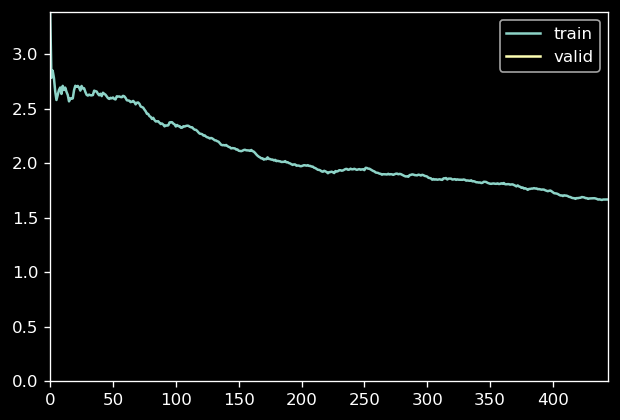

In [18]:


if PRETRAINED_FLAG:
    print(f'FROZEN_EPOCHS:  {FROZEN_EPOCHS}')
print(f'EPOCHS:         {EPOCHS}')
print(f'Learning Rate:  {LR_CHOICE}\n\n')

if PRETRAINED_FLAG == True:
    learn.fit_flat_cos(FROZEN_EPOCHS, LR_CHOICE)


## Manually set up the unfrozen runs

In [30]:
learn.unfreeze()

In [31]:
lr_min,lr_steep = learn.lr_find()
plt.axvline(lr_min, ls='--', color='red', label=f'lr_min={round(lr_min,6)}')
plt.axvline(LR_CHOICE/2, ls='--', color='yellow', label=f'LR_CHOICE/2={round(LR_CHOICE/2,6)}')
plt.axvline(lr_steep, ls='--', color='grey', label=f'lr_steep={round(lr_steep,6)}')
plt.axvline(2e-5, ls='--', color='green', label=f'{round(2e-5,6)}')
plt.axvline(7e-5, ls='--', color='orange', label=f'{round(7e-5,6)}')

plt.legend()
plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [21]:
print(f"Minimum/10: {lr_min:.2e}, steepest point: {lr_steep:.2e}, LR_CHOICE/2: {LR_CHOICE / 2}")

Minimum/10: 5.25e-06, steepest point: 1.58e-06, LR_CHOICE/2: 0.005


## Pick a new Learning Rate

In [32]:
# LR_CHOICE_UNFROZ = lr_min/LR_DIV
# LR_CHOICE_UNFROZ = LR_CHOICE / 2
# LR_CHOICE_UNFROZ = 0.00015
# LR_CHOICE_UNFROZ = 10e-5
# LR_CHOICE_UNFROZ = 0.00008
# LR_CHOICE_UNFROZ = 5.5e-5
LR_CHOICE_UNFROZ = 0.001
# LR_CHOICE_UNFROZ = 6e-5
# LR_CHOICE_UNFROZ = lr_min

### Train

In [33]:
EPOCHS = 15

In [34]:
print(f'EPOCHS:         {EPOCHS}')
print(f'Learning Rate:  {LR_CHOICE_UNFROZ}\n\n')

EPOCHS:         15
Learning Rate:  0.001




epoch,train_loss,valid_loss,error_rate,accuracy,time
0,1.272397,1.242161,0.463253,0.536747,08:46
1,1.233322,1.162204,0.408340,0.591660,08:38
2,1.198332,1.138648,0.387696,0.612304,08:35
3,1.213124,1.116279,0.387283,0.612717,08:47
4,1.143216,1.074751,0.357969,0.642031,08:16
5,1.100078,1.047119,0.341866,0.658134,08:11
6,1.107395,1.019874,0.314616,0.685384,08:11
7,1.080494,0.984920,0.292320,0.707680,08:11
8,1.052612,1.008451,0.314616,0.685384,08:11
9,1.043982,0.961964,0.288192,0.711808,08:11


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

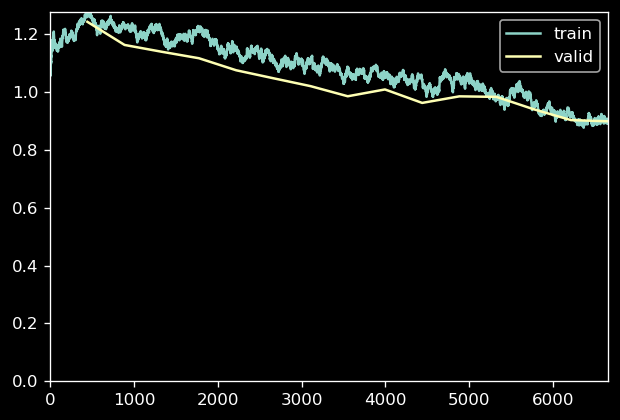

In [35]:
learn.fit_flat_cos(EPOCHS, LR_CHOICE_UNFROZ)

<br>
<br>

## Persist the Model

In [36]:
learn.export(f'../models/{RUN_NAME}.pkl')
# path = Path('../models')
# path.ls(file_exts='.pkl')

<br>
<br>

### Show some Results

In [40]:
learn.show_results()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

<br>
<hr>
<br>
<br>
<br>

# Validation Set (not test set) Analysis

<br>

### Plot Losses

In [41]:
# learn.recorder.plot_loss()
# plt.ylabel('Loss')
# plt.xlabel('Batches Processed')

<br>

### Visualize with a confusion Matrix

In [42]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(8,8))

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [43]:
interp.most_confused()[:10]

[('cbb', 'healthy', 94),
 ('cbb', 'cbsd', 62),
 ('healthy', 'cbb', 59),
 ('healthy', 'cbsd', 56),
 ('cgm', 'healthy', 41),
 ('healthy', 'cgm', 39),
 ('cmd', 'cgm', 37),
 ('cbsd', 'healthy', 34),
 ('cgm', 'cbsd', 30),
 ('cgm', 'cmd', 26)]

<br>
<br>

## Classification Report

In [44]:
interp.print_classification_report()

              precision    recall  f1-score   support

         cbb       0.76      0.62      0.69       469
        cbsd       0.70      0.81      0.75       472
         cgm       0.79      0.79      0.79       491
         cmd       0.86      0.85      0.86       502
     healthy       0.63      0.64      0.64       488

    accuracy                           0.74      2422
   macro avg       0.75      0.74      0.74      2422
weighted avg       0.75      0.74      0.74      2422



<br>

### Show the top 15 most error prone images

In [45]:
interp.plot_top_losses(15, nrows=5)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

## Validation

In [46]:
test_learn = learn

# load_learner('../models/20210205-1716 - arch=xresnet34 - samples=1800 frozen=1 epochs=40 bs=32 res=340.pkl', cpu=False)
# load_model(f'models/{RUN_NAME}_26.pth', test_learn, opt=Adam, with_opt=False)


In [47]:
def get_test_fnames(path):
    retlist = []
    
    for l in test_flist.values():
        for f in l:
            retlist.append(f)
            
    return random.sample(retlist, len(retlist))

In [48]:
test_db = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_test_fnames,
    get_y=parent_label, 
    item_tfms=Resize(RESOLUTION, method='bilinear')) #,
#     item_tfms=CropPad(RESOLUTION, pad_mode='zeros'))
#    ,    batch_tfms=aug_transforms(do_flip=True, size=RESOLUTION, batch=False, max_zoom=1.0, mult=1, pad_mode='zeros'))


dls = test_db.dataloaders(get_test_fnames, bs=BATCH_SIZE)

test_dl = dls.test_dl(get_test_fnames('None'), with_labels=True)

####  Get the Inferrences on the Test Set

In [ ]:
inputs, preds, targs, decoded, losses = test_learn.get_preds(dl=test_dl, with_input=True, with_decoded=True, with_loss=True)


In [ ]:
interp = ClassificationInterpretation(dl=test_dl, inputs=inputs, preds=preds, targs=targs, decoded=decoded, losses=losses )

<br>

### Visualize with a confusion Matrix

In [ ]:
interp.plot_confusion_matrix(figsize=(8,8))

In [ ]:
interp.most_confused()[:10]

<br>
<br>

## Classification Report

In [ ]:
interp.print_classification_report()

In [ ]:
interp.plot_top_losses(k=15)

## Archive this version of the notehook

In [ ]:
import os
import shutil

# Allow Jupyter the opportunity to autosave
# !sleep 20
# time = '20210122-2356'
# copy the notebook file - the prefix links it to the saved model
shutil.copyfile('FastAI Cassava Disease Classification.ipynb', f'.Archive/{time} - FastAI Cassava Disease Classification.ipynb')